# Importing Essential Libraries

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras import Model, Input

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("huthayfahodeb/captcha-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/huthayfahodeb/captcha-dataset/versions/2


In [ ]:
ls /root/.cache/kagglehub/datasets/huthayfahodeb/captcha-dataset/versions/2/captcha_data.csv

/root/.cache/kagglehub/datasets/huthayfahodeb/captcha-dataset/versions/2/captcha_data.csv


# Loads CAPTCHA dataset

In [ ]:
df = pd.read_table('/root/.cache/kagglehub/datasets/huthayfahodeb/captcha-dataset/versions/2/captcha_data.csv', sep=',', dtype={'solution': str})

In [ ]:
df.head()

,image_path,solution
0,train-images/image_train_1.png,000073
1,train-images/image_train_2.png,000372
2,train-images/image_train_3.png,000454
3,train-images/image_train_4.png,000634
4,train-images/image_train_5.png,000716


In [ ]:
df.columns

Index(['image_path', 'solution'], dtype='object')

In [ ]:
df.dtypes

,0
image_path,object
solution,object


# Preprocesses solutions and splits dataset into train, test, and validation sets.

In [ ]:
def preprocess_solution(solution):
    return np.array([int(char) for char in solution], dtype=np.float32)

In [ ]:
train_df = df[df['image_path'].str.startswith('train-images/')]
test_df = df[df['image_path'].str.startswith('test-images/')]
val_df = df[df['image_path'].str.startswith('validation-images/')]

In [ ]:
test_df.head()

,image_path,solution
8000,test-images/image_test_1.png,001251
8001,test-images/image_test_2.png,001335
8002,test-images/image_test_3.png,002402
8003,test-images/image_test_4.png,002769
8004,test-images/image_test_5.png,002821


In [ ]:
train_image_paths = train_df['image_path'].values
train_solutions = train_df['solution'].apply(preprocess_solution).values

test_image_paths = test_df['image_path'].values
test_solutions = test_df['solution'].apply(preprocess_solution).values

val_image_paths = val_df['image_path'].values
val_solutions = val_df['solution'].apply(preprocess_solution).values

In [ ]:
train_image_paths

array(['train-images/image_train_1.png', 'train-images/image_train_2.png',
       'train-images/image_train_3.png', ...,
       'train-images/image_train_5998.png',
       'train-images/image_train_5999.png',
       'train-images/image_train_6000.png'], dtype=object)

In [ ]:
train_solutions

array([array([0., 0., 0., 0., 7., 3.], dtype=float32),
       array([0., 0., 0., 3., 7., 2.], dtype=float32),
       array([0., 0., 0., 4., 5., 4.], dtype=float32), ...,
       array([9., 9., 9., 2., 6., 4.], dtype=float32),
       array([9., 9., 9., 5., 7., 6.], dtype=float32),
       array([9., 9., 9., 8., 6., 5.], dtype=float32)], dtype=object)

# Loads and preprocesses images, stacks solutions for train, test, and validation sets.

In [ ]:
def read_images(image_paths, subset_path=''):

    images = [np.array(Image.open(f"{subset_path}{path}").convert('RGB')) for path in image_paths]
    return  np.array(images)

In [ ]:
train_images = read_images(train_image_paths, subset_path='/root/.cache/kagglehub/datasets/huthayfahodeb/captcha-dataset/versions/2/train-images/')
test_images = read_images(test_image_paths, subset_path='/root/.cache/kagglehub/datasets/huthayfahodeb/captcha-dataset/versions/2/test-images/')
val_images = read_images(val_image_paths, subset_path='/root/.cache/kagglehub/datasets/huthayfahodeb/captcha-dataset/versions/2/validation-images/')


In [ ]:
train_images.shape , test_images.shape, val_images.shape

((6000, 50, 200, 3), (2000, 50, 200, 3), (2000, 50, 200, 3))

In [ ]:
train_solutions = np.vstack(train_solutions)
test_solutions = np.vstack(test_solutions)
val_solutions = np.vstack(val_solutions)

In [ ]:
train_solutions.shape

(6000, 6)

# Builds and trains a ResNet50-based model for CAPTCHA recognition

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(50, 200, 3))

base_model.trainable = True

inputs = Input(shape=(50, 200, 3))

x = base_model(inputs)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)

outputs = layers.Dense(6)(x)

model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='mse')

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 50, 200, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 2, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,769,670 (94.49 MB)

 Trainable params: 24,716,550 (94.29 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
history = model.fit(
    train_images,
    train_solutions,
    validation_data=(val_images, val_solutions),
    epochs=35
)

Epoch 1/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - loss: 0.0792 - val_loss: 3.1311
Epoch 2/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - loss: 0.3055 - val_loss: 0.8912
Epoch 3/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - loss: 0.1377 - val_loss: 0.1889
Epoch 4/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - loss: 0.0676 - val_loss: 0.1292
Epoch 5/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - loss: 0.0429 - val_loss: 0.1025
Epoch 6/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - loss: 0.0282 - val_loss: 0.1029
Epoch 7/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - loss: 0.0235 - val_loss: 0.1006
Epoch 8/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - loss: 0.0215 - val_loss: 0.0804
Epoch 9/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 104ms/step - loss: 0.0164 - val_loss: 0.0810
Epoch 10/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - loss: 0.0177 - val_loss: 0.0819
Epoch 11/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 104ms/step - loss: 0.0160 - val_loss: 0.0918
Epoch 12/35
188/188

## Evaluates the model on test data.

In [ ]:
test_loss = model.evaluate(test_images, test_solutions)
print(f"Test Loss: {test_loss}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0719
Test Loss: 0.10212192684412003


# Predicts CAPTCHA solution from an image using the trained model

In [ ]:
def output_to_solution(prediction):
    prediction = np.round(prediction).astype(int)

    solution = ''.join(map(str, prediction[0])).lstrip('0')

    return solution

def predict_and_plot(image_path, model):
    img = Image.open(image_path)

    img_array = np.array(img)

    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)

    prediction = output_to_solution(prediction)

    plt.imshow(img)
    plt.title(f'Prediction: {prediction}')
    plt.axis('off')
    plt.show()

    return prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


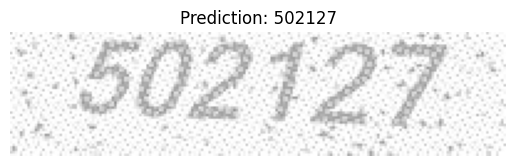

Predicted output: 502127


In [ ]:
image_path = '/root/.cache/kagglehub/datasets/huthayfahodeb/captcha-dataset/versions/2/test-images/test-images/image_test_1002.png'
prediction = predict_and_plot(image_path, model)
print("Predicted output:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


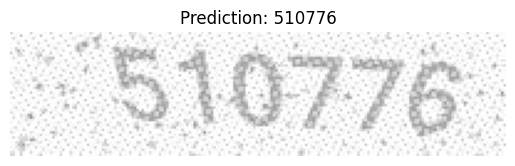

Predicted output: 510776


In [ ]:
image_path = '/root/.cache/kagglehub/datasets/huthayfahodeb/captcha-dataset/versions/2/test-images/test-images/image_test_1015.png'
prediction = predict_and_plot(image_path, model)
print("Predicted output:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


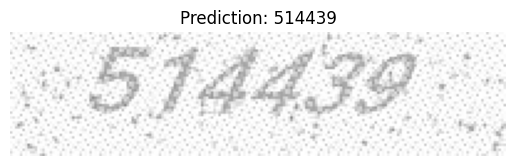

Predicted output: 514439


In [ ]:
image_path = '/root/.cache/kagglehub/datasets/huthayfahodeb/captcha-dataset/versions/2/test-images/test-images/image_test_1024.png'
prediction = predict_and_plot(image_path, model)
print("Predicted output:", prediction)

In [ ]:
model.save('captcha_model.h5')

In [ ]:
model.save_weights('captcha.weights.h5')

In [ ]:
from google.colab import files
files.download('captcha_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/captcha_model.h5')


In [ ]:
model.save('/content/drive/MyDrive/captcha_weights.h5')


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/root/.cache/kagglehub/datasets/huthayfahodeb/captcha-dataset/versions/2/validation-images/captcha_model.h5', compile=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


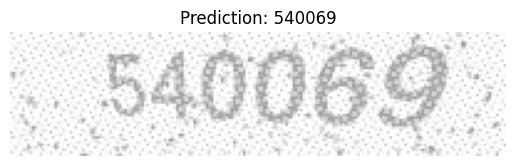

Predicted output: 540069


In [ ]:
image_path = '/root/.cache/kagglehub/datasets/huthayfahodeb/captcha-dataset/versions/2/validation-images/validation-images/image_validation_1061.png'
prediction = predict_and_plot(image_path, model)
print("Predicted output:", prediction)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
